# Model

In [33]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [1]:
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse import lil_matrix
import matplotlib.pyplot as plt
import pandas as pd
import math

## Data Preprocessing

In [2]:
recs = pd.read_csv('data/pruned.csv')

In [3]:
recs.head()

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
0,534380,0,0,2022-10-08,True,40.6,10531,22
1,42700,6,2,2019-10-19,False,5.9,185293,27
2,602960,0,0,2022-01-05,True,41.9,319249,58
3,976730,0,0,2021-11-25,False,21.1,747545,67
4,1091500,2,0,2022-10-30,True,18.1,2113544,127


In [4]:
USED_COLS = ['app_id', 'is_recommended', 'user_id']

recs = recs[USED_COLS]
recs.head()

,app_id,is_recommended,user_id
0,534380,True,10531
1,42700,False,185293
2,602960,True,319249
3,976730,False,747545
4,1091500,True,2113544


## Data Class

In [5]:
from RecData import RecData

In [6]:
class Metrics:
    def rmse(self, predictions):
        return math.sqrt(sum((prediction - true_rating)**2 for _, _, prediction, true_rating in predictions)/len(predictions))

In [7]:
rec_data = RecData()
rec_data.create_from_dataframe(recs)

In [8]:
train_data, test = rec_data.leave_k_out_split()

## Simple Model

In [9]:
def item_averages(M):
    # Division by 0 -> no data for item -> predict average of all items
    with np.errstate(invalid='ignore'):
        # Take item averages
        averages = (np.sum(M.toarray(), axis=0)/np.count_nonzero(M.toarray(), axis=0))

        # Fill na with averages over all items
        averages = np.nan_to_num(averages, nan=np.nanmean(averages))
    return averages

In [10]:
class AveragePredictor:
    """Simple model which always predicts the average value of an item."""
    def fit(self, M):
        self._averages = item_averages(M)
        
    def predict(self, pairs):
        """Parameters:
        pairs - user-item pairs to predict"""
        predictions = []
        for user, item in pairs:
            predictions.append((user, item, self._averages[item]))

        return predictions

In [11]:
predictor = AveragePredictor()
predictor.fit(train_data.get_matrix())

In [12]:
predictions = predictor.predict([(user, item) for user, item, _ in test])
predictions = [prediction + (test[i][2],) for i, prediction in enumerate(predictions)]
metrics = Metrics()
metrics.rmse(predictions)

0.3709682020560274

## SVD

In [96]:
from scipy.sparse.linalg import norm as sparse_norm
from collections import defaultdict
import time
import random

class SVDPredictor:
    """SVD for collaborative filtering"""
    def __init__(self, num_users, num_items, k=100, learning_rate=0.01, epochs=5, C=0.02):
        self._num_users = num_users
        self._num_items = num_items
        
        self._k = k
        self._learning_rate = learning_rate
        self._epochs = epochs
        self._C = C
        
        self._user_features = np.random.normal(size=(self._num_users, self._k), scale=0.01)
        self._item_features = np.random.normal(size=(self._num_items, self._k), scale=0.01)
        
        self._M = None
        self._train_errors = None
        self._val_errors = None
    
    def fit(self, M, validation_set=None):
        self._M = M
        self._train_errors = []
        if validation_set:
            self._val_errors = []
        
        users, items = M.nonzero()
        num_samples = len(users)
        mask = (M != 0)
        
        for epoch in range(self._epochs):
            start_time = time.time()
            
            for i in random.sample(range(num_samples), k=num_samples):
                user = users[i]
                item = items[i]
                
                diff = self._learning_rate*(M[user, item] - self._user_features[user, :] @ np.transpose(self._item_features[item, :]))
                
                # Compute user features update
                new_user_features = self._user_features[user, :] + diff*self._item_features[item, :]
                
                # Compute item features update
                self._item_features[item, :] += diff*self._user_features[user, :]
                
                self._user_features[user, :] = new_user_features
                
            big_diff = M - self._user_features @ np.transpose(self._item_features)
            
            # Mask to ignore error from missing reviews
            error = sparse_norm(mask.multiply(big_diff)) / np.sqrt(num_samples)
            self._train_errors.append(error)
            
            if validation_set:
                predictions = self.predict([(user, item) for user, item, _ in validation_set])
                predictions = [prediction + (validation_set[i][2],) for i, prediction in enumerate(predictions)]
                metrics = Metrics()
                val_error = metrics.rmse(predictions)
                self._val_errors.append(val_error)
            
            print("Epoch", epoch, end="/")
            print("Training error:", error, end="/")
            if validation_set:
                print("Validation error:", val_error, end="/")
            print("Time:", round(time.time() - start_time, 2), "seconds")
            
    def top_n(self, user, n=10):
        if self._M is None:
            raise RuntimeError("Please ensure to call fit before generating top n")
        users, items = self._M.nonzero()
        
        users_rated = []
        for i in range(len(users)):
            if users[i] == user:
                users_rated.append(items[i])
        
        top = []
        for item in range(self._num_items):
            # Do not add items for which rating already exists
            if item in users_rated:
                continue
            predicted_rating = self._user_features[user, :] @ np.transpose(self._item_features)[:, item]
            
            top.append((predicted_rating, item))
            top.sort(key=lambda x: x[0], reverse=True)
            top = top[:min(n, len(top))]
        
        return top
        
        
    def predict(self, pairs):
        predictions = []
        for user, item in pairs:
            prediction = (self._user_features[user, :] @ np.transpose(self._item_features)[:, item])
            predictions.append((user, item, prediction))
        
        return predictions
    
    def get_train_errors(self):
        return self._train_errors
    
    def get_val_errors(self):
        return self._val_errors

Epoch 0/Training error: 1.8493220956173608/Validation error: 1.8527649537014275/Time: 40.88 seconds


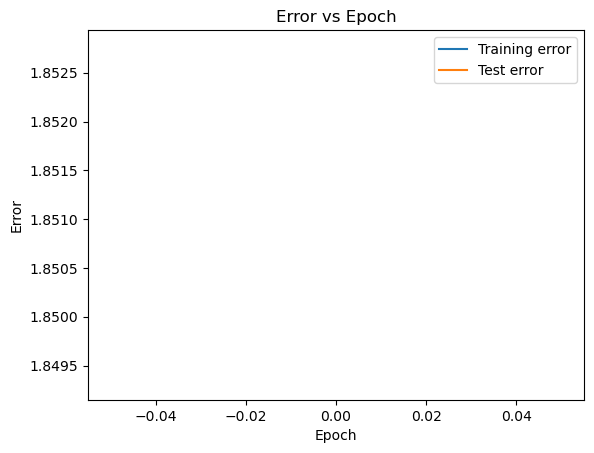

Test rmse 1.8527649537014275


UnboundLocalError: local variable 'top' referenced before assignment

In [97]:
EPOCHS = 1

# Fit and predict with svd
svd_predictor = SVDPredictor(train_data.get_num_users(), train_data.get_num_items(), k=10, epochs=EPOCHS, learning_rate=0.01, C=0)
svd_predictor.fit(train_data.get_matrix(), validation_set=test)

# Plot error
errors = svd_predictor.get_train_errors()
val_errors = svd_predictor.get_val_errors()
plt.plot(range(EPOCHS), errors, label='Training error')
plt.plot(range(EPOCHS), val_errors, label='Test error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Error vs Epoch')
plt.legend()
plt.show()

# Compute rmse
predictions = svd_predictor.predict([(user, item) for user, item, _ in test])
predictions = [prediction + (test[i][2],) for i, prediction in enumerate(predictions)]
metrics = Metrics()
print("Test rmse", metrics.rmse(predictions))

# Test top-n list
top_n = svd_predictor.top_n(0)
print(top_n)